# TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL

### 이 노트는 아래의 웹사이트의 코드를 따라가며 해설하였다.

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

#### 데이터셋은 다음 주소에서 다운로드 : https://download.pytorch.org/tutorial/hymenoptera_data.zip  
#### 다운로드 후에는 아래 코드 주석에 명시한대로 적절한 디렉토리에 옮길 것

#### two major transfer learning scenarios

- Finetuning the convnet: Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
- ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [1]:
from __future__ import print_function, division

import time
import os
import copy

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms


plt.ion()   # interactive mode

### 1. Load Data

- Classify ants and bees
- 120 training images each for ants and bees, 75 validation images for each class
- Very small dataset to generalize upon, if trained from scratch

####  아래 transforms 에 대해서는 https://pytorch.org/docs/stable/torchvision/transforms.html 참조

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Crop the given PIL Image to random size and aspect ratio.
        transforms.RandomHorizontalFlip(),  # Horizontally flip the given image randomly with a given probability.
        transforms.ToTensor(),  # Converts a PIL Image or numpy.ndarray to tensor.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # Resize the input PIL Image to the given size.
        transforms.CenterCrop(224),  # Crops the given PIL Image at the center.
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# "train" and "val" directories in the downloaded "hymenoptera_data" folder
# are supposed to be located in an appropriate path. (Here, it's D:\Dataset\AntsBeesImageData.)
data_dir = 'D:\Dataset\AntsBeesImageData'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
print(image_datasets['train'])
print('='*128)
print(image_datasets['val'])
print('='*128)
print(class_names)

Dataset ImageFolder
    Number of datapoints: 244
    Root location: D:\Dataset\AntsBeesImageData\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 153
    Root location: D:\Dataset\AntsBeesImageData\val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['ants', 'bees']


In [4]:
# 첫번째 train data 의 사이즈
image_datasets['train'][0][0].size()

torch.Size([3, 224, 224])

In [5]:
# train, val 데이터 갯수
print(dataset_sizes)

{'train': 244, 'val': 153}


In [6]:
trainiter = iter(dataloaders['train'])
valiter = iter(dataloaders['val'])
trainex = trainiter.next()
valex = valiter.next()
print(trainex[0].size(), trainex[1])  # data 와 label
print(valex[0].size(), valex[1])

torch.Size([4, 3, 224, 224]) tensor([0, 1, 1, 1])
torch.Size([4, 3, 224, 224]) tensor([0, 0, 0, 0])


In [7]:
# Mini-batch  갯수
print(len(dataloaders['train']), len(dataloaders['val']))

61 39


### 2. Visualize a few images

- Visualize a few training images so as to understand the data augmentations

torch.Size([3, 228, 906])


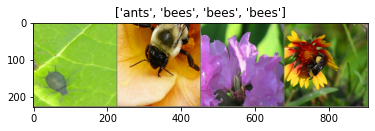

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # inp is torch.Tensor and has shape (C, H, W).
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
# 각 그림에 2px 씩 padding 이 붙는다.
out = torchvision.utils.make_grid(inputs)
print(out.size())

imshow(out, title=[class_names[x] for x in classes])

### 3. Training the mode

- Scheduling the learning rate
- Saving the best model

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### 4. Visualizing the model predictions

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}  truth: {}'.format(class_names[preds[j]],
                                                               class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 5. Finetuning the convnet

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#### - Train and evaluate

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5984 Acc: 0.6557
val Loss: 0.2107 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.3986 Acc: 0.8279
val Loss: 0.4946 Acc: 0.8039

Epoch 2/24
----------
train Loss: 0.5066 Acc: 0.8197
val Loss: 0.2889 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4061 Acc: 0.8443
val Loss: 0.4492 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.5103 Acc: 0.8115
val Loss: 0.3274 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4417 Acc: 0.8689
val Loss: 0.3104 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.5026 Acc: 0.7992
val Loss: 0.4034 Acc: 0.8431

Epoch 7/24
----------
train Loss: 0.3845 Acc: 0.8484
val Loss: 0.3101 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3575 Acc: 0.8443
val Loss: 0.3844 Acc: 0.8627

Epoch 9/24
----------
train Loss: 0.3160 Acc: 0.8607
val Loss: 0.2932 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3146 Acc: 0.8525
val Loss: 0.2895 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2766 Acc: 0.8934
val Loss: 0.2827 Acc: 0.9085

Ep

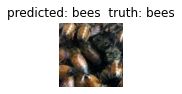

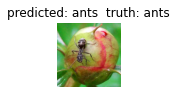

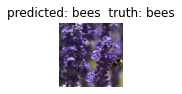

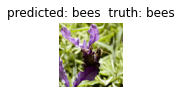

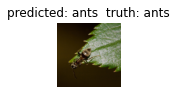

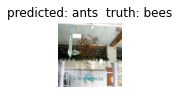

In [13]:
visualize_model(model_ft)

### 7. ConvNet as fixed feature extractor

- 맨 마지막의 fully-connected(fc) layer 만 랜덤 초기화하여, 학습한다.

In [14]:
model_conv = torchvision.models.resnet18(pretrained=True)

# 원래는 모든 parameters 가 requires_grad = True 로 설정되어 있다.
# 아래 코드를 통해, 모든 parameter tensors 에 대해 requires_grad = False 가 된다.
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default.
# nn.Linear generates tensor with requres_grad = True.
# 즉, 이 맨 마지막 fc layer 만 requires_grad = True 로서, 학습이 이루어진다.
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#### - Train and evaluate

In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4847 Acc: 0.7459
val Loss: 0.2698 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.3973 Acc: 0.8320
val Loss: 0.2071 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4557 Acc: 0.8074
val Loss: 0.1960 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4799 Acc: 0.8074
val Loss: 0.3411 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.4962 Acc: 0.7828
val Loss: 0.6063 Acc: 0.7582

Epoch 5/24
----------
train Loss: 0.5603 Acc: 0.7869
val Loss: 0.2837 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.4984 Acc: 0.7910
val Loss: 0.1921 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.4259 Acc: 0.8115
val Loss: 0.2131 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3121 Acc: 0.9016
val Loss: 0.1863 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3451 Acc: 0.8402
val Loss: 0.1767 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3817 Acc: 0.8484
val Loss: 0.2181 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3571 Acc: 0.8484
val Loss: 0.2088 Acc: 0.9608

Ep

#### NOTE ) 맨 마지막 fc layer 만 학습했을때, 정확도가 더 높다!

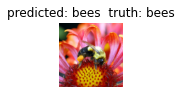

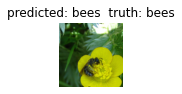

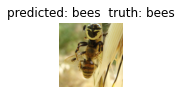

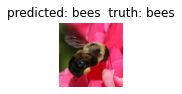

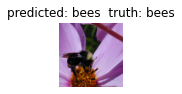

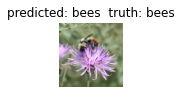

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()